## Analyzing 2023 Volleyball Nations League (VNL) data

#### Questions

1. Outside Hitter receive and dig as well as libero ?
2. Outside hitter attack as well as Opposite hitter ?
3. Can we determine the role of each position ?

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE

sns.set_theme()

In [3]:

def plot_spider(x, labels, ax=None, **kw_arg):
    """Plot a spider chart

    Parameters
    ----------
    x : list/array
        The values list
    labels : list
        The labels of the value to plot
    ax : matplotlib.axes._axes.Axes, optional
        The plot axes, by default None

    Returns
    -------
    matplotlib.axes._axes.Axes
        The plot axes of the spider chart
    """

    num_vars = len(labels)

    # Angles for the variables' name
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles.append(angles[0])

    # Plot axis
    if not ax:
        _, ax = plt.subplots(subplot_kw={'polar': True})
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    # Background of the charts
    ax.spines['polar'].set_visible(False)
    
    max_vals = [1] * (num_vars + 1)
    ax.plot(angles, max_vals, color="#555555", alpha=1, linewidth=0.7)

    for val in np.linspace(0, 1, 10, endpoint=False):
        ax.plot(angles, [val]* (num_vars+1), color="#555555", linewidth=0.5, alpha=0.2)
    
    if not isinstance(x, (list)):
        x = list(x)

    x.append(x[0])

    ax.fill(angles,x , alpha=0.2, **kw_arg)
    ax.plot(angles, x, linewidth=0.7, **kw_arg)
    
    return ax


In [4]:
def stat_test(df, alternative='two-side', alpha=0.05, alpha_param=0.05):
    """Run statistic test

    Parameters
    ----------
    df : list(list)
        Data to perform the test
    alternative : string, optional
        The alternative hypothesis (less, two-side, greater), by default 'two-side'
    alpha : float, optional
        The alpha of the test, by default 0.05
    alpha_param : float, optional
        The alpha of the test to know if each variable follow a normal distribution, by default 0.05
    """

    parametric = True

    print("Test if our variables are normaly distributed", end="\n\n")
    for i in range(len(df)):
        _, p_val = shapiro(df[i])
        print(f"p-value = {p_val:.4f}, alpha = {alpha_param}", end=" -> ")
        if p_val >= alpha_param:
            # print(f"Fail to reject null hypothesis.{col} is normaly distributed")
            print(f"Assume that {i} is normaly distributed")
        else:
            parametric = False
            # print(f"Reject the null hypothesis with {alpha_param*100}% risk of type I error.")
            print(f"Assume that {i} is not normaly distributed with {alpha_param*100}% risk of type I error")
    
    print()
    
    # Statistic test
    if parametric:
        print("Proceed to t-test")
        _, pval = ttest_ind(df[0],
                            df[1],
                            alternative=alternative)
    
    else:
        print("Proceed to Mann Whitney test")
        _, pval = mannwhitneyu(df[0],
                               df[1],
                               alternative=alternative)

    print(f"p-value = {pval:.4f}, alpha = {alpha}")
    if pval >= alpha_param:
        print(f"Fail to reject null hypothesis.")
    else:
        parametric = False
        print(f"Reject the null hypothesis with {alpha_param*100}% risk of type I error.")
8

8

In [5]:
vnl23 = pd.read_csv(r"./row_data/VNL2023.csv")
vnl23.head(3)

,Player,Country,Age,Attack,Block,Serve,Set,Dig,Receive,Position
0,Ichikawa Yuki,Japan,28,15.80,1.13,1.40,0.07,4.80,5.60,OH
1,Romano Yuri,Italy,26,12.33,1.07,1.47,0.00,3.87,0.00,OP
2,Abdel-Aziz Nimir,Nederland,31,15.33,0.67,2.08,0.00,3.17,0.25,OP


In [6]:
vnl23.describe()

,Age,Attack,Block,Serve,Set,Dig,Receive
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,27.809160,5.642672,0.845573,0.535802,2.192595,3.428397,1.684198
std,4.186268,4.256229,0.700896,0.454346,6.031587,2.077823,1.989939
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.530000,0.000000
25%,25.000000,2.800000,0.370000,0.240000,0.000000,1.920000,0.000000
50%,27.000000,5.170000,0.690000,0.420000,0.000000,3.000000,0.330000
75%,30.000000,8.600000,1.140000,0.760000,0.000000,4.510000,3.385000
max,41.000000,15.800000,4.080000,2.080000,26.890000,11.440000,6.690000


In [7]:
vnl23.describe(include='object')

,Player,Country,Position
count,131,131,131
unique,131,16,5
top,Ichikawa Yuki,Poland,OH
freq,1,10,42


1. ##### Outside Hitter receive and dig as well as libero ?

In [8]:
# Libero receive
lib_oh_rcve = vnl23[vnl23['Position'].isin(('L', 'OH'))][['Player', 'Age', 'Position', 'Receive', 'Dig']]
lib_oh_rcve.head(3)

,Player,Age,Position,Receive,Dig
0,Ichikawa Yuki,28,OH,5.60,4.80
4,Takahashi Ran,22,OH,5.07,6.40
6,Urnaut Tine,35,OH,5.00,5.85


In [9]:
lib_oh_rcve['Position'].value_counts()

Position
OH    42
L     16
Name: count, dtype: int64

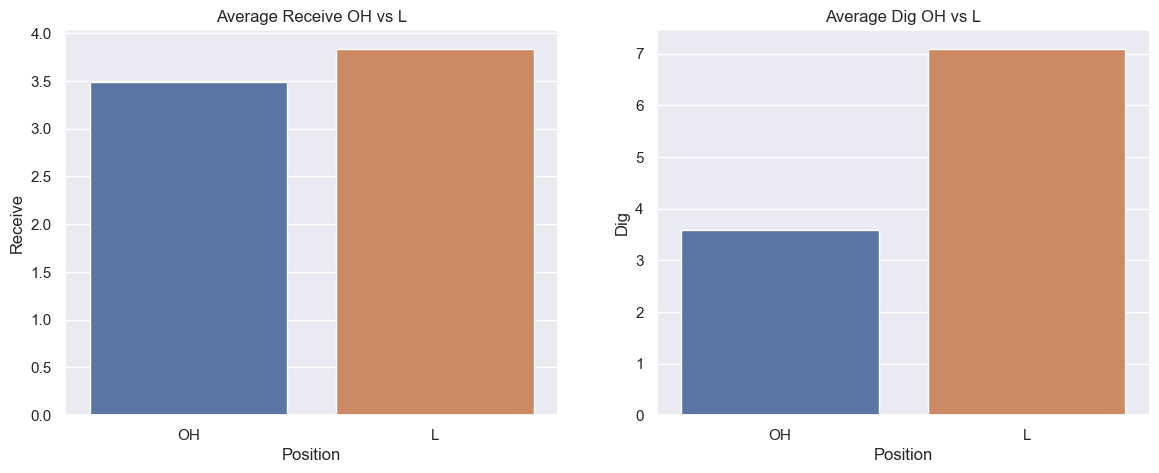

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=lib_oh_rcve,
            y='Receive',
            x='Position',
            hue='Position',
            errorbar=None,
            ax=ax1)

ax1.set_title("Average Receive OH vs L")

sns.barplot(data=lib_oh_rcve,
            y='Dig',
            x='Position',
            hue='Position',
            errorbar=None,
            ax=ax2)

ax2.set_title("Average Dig OH vs L")
plt.show()

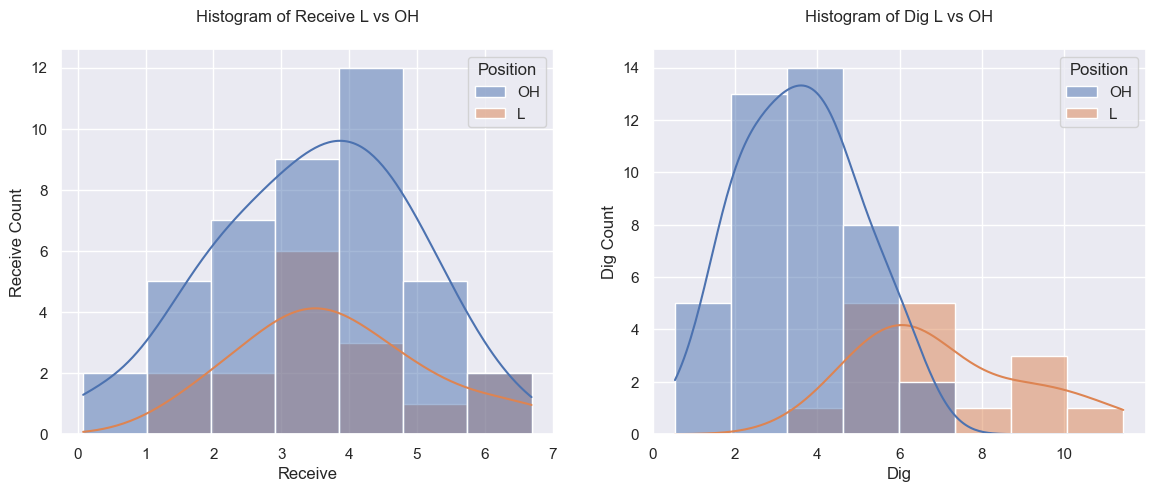

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(lib_oh_rcve,
                x='Receive',
                hue='Position',
                kde=True,
                ax=ax1)
ax1.set_title('Histogram of Receive L vs OH', y=1.05)
ax1.set_ylabel('Receive Count')

sns.histplot(lib_oh_rcve,
                x='Dig',
                hue='Position',
                kde=True,
                ax=ax2)
ax2.set_title('Histogram of Dig L vs OH', y=1.05)
ax2.set_ylabel('Dig Count')

plt.show()

On the barchart we can see that on average Libero is more skilled on receive and dig.<br>
The different histograms show us a kind of normal distribution for each sample of data (Libero receive, outside hitter receive, etc).

We will perform two tests to see if there is a significant difference with 5% alpha.

H0 : Mean(Receive)_L = Mean(Receive)_OH <br>
H1 : Mean(Receive)_L > Mean(Receive)_OH 

In [12]:
stat_test([lib_oh_rcve[lib_oh_rcve['Position'] == 'L']['Receive'],
           lib_oh_rcve[lib_oh_rcve['Position'] == 'OH']['Receive']], 'greater')

Test if our variables are normaly distributed

p-value = 0.5279, alpha = 0.05 -> Assume that 0 is normaly distributed
p-value = 0.9683, alpha = 0.05 -> Assume that 1 is normaly distributed

Proceed to t-test
p-value = 0.2042, alpha = 0.05
Fail to reject null hypothesis.


The p-value is greater than alpha , We fail to reject the null hypothesis.<br>
We can conclude based on our data that Outside hitter receive as well as Libero.

H0 : Mean(Dig)_L = Mean(Dig)_OH <br>
H1 : Mean(Dig)_L > Mean(Dig)_OH 

In [13]:

stat_test([lib_oh_rcve[lib_oh_rcve['Position'] == 'L']['Dig'],
           lib_oh_rcve[lib_oh_rcve['Position'] == 'OH']['Dig']],
           alternative = 'greater')

Test if our variables are normaly distributed

p-value = 0.2012, alpha = 0.05 -> Assume that 0 is normaly distributed
p-value = 0.7635, alpha = 0.05 -> Assume that 1 is normaly distributed

Proceed to t-test
p-value = 0.0000, alpha = 0.05
Reject the null hypothesis with 5.0% risk of type I error.


The p-value is lower than alpha. We reject the null hypothesis with 5% risk of type I error.<br>
We can conclude that Libero is more skilled on digging than outside hitter.

2. ##### Outside hitter attack as well as Oppositeeeeeeeeeeeeee hitter ?

In [14]:
att_oh_op = vnl23[vnl23['Position'].isin(('OH', 'OP'))]
att_oh_op.head(3)

,Player,Country,Age,Attack,Block,Serve,Set,Dig,Receive,Position
0,Ichikawa Yuki,Japan,28,15.80,1.13,1.40,0.07,4.80,5.60,OH
1,Romano Yuri,Italy,26,12.33,1.07,1.47,0.00,3.87,0.00,OP
2,Abdel-Aziz Nimir,Nederland,31,15.33,0.67,2.08,0.00,3.17,0.25,OP


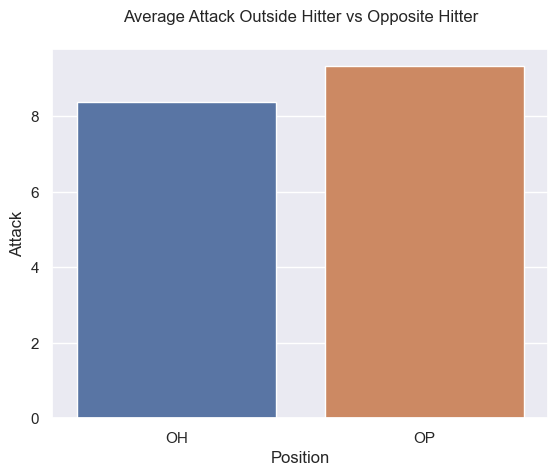

In [15]:
g = sns.barplot(data=att_oh_op,
                x='Position',
                y='Attack',
                hue='Position',
                errorbar=None)

g.set_title("Average Attack Outside Hitter vs Opposite Hitter", y=1.05)
plt.show()

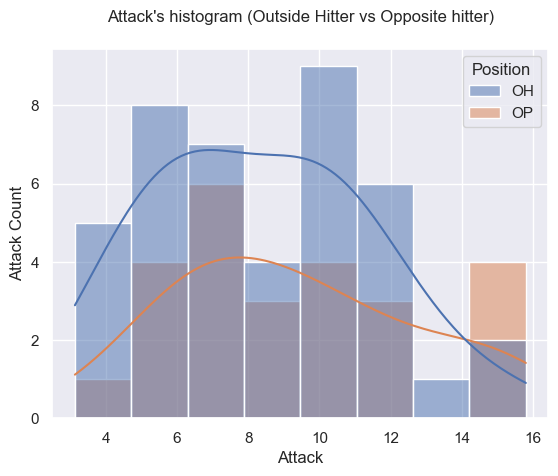

In [16]:
g = sns.histplot(data=att_oh_op,
                x='Attack',
                hue='Position',
                kde=True)

g.set_title("Attack's histogram (Outside Hitter vs Opposite hitter)", y=1.05)
g.set_ylabel("Attack Count")
plt.show()

We can see in the barplot that on average Opposite are higher.
Let's see if this difference is significant.

H0: Mean(Attack)_OH = Mean(Attack)_OP <br>
H1: Mean(Attack)_OH < Mean(Attack)_OP

In [17]:
stat_test([att_oh_op[att_oh_op['Position'] == 'OH']['Attack'],
           att_oh_op[att_oh_op['Position'] == 'OP']['Attack']],
           alternative='less')

Test if our variables are normaly distributed

p-value = 0.5673, alpha = 0.05 -> Assume that 0 is normaly distributed
p-value = 0.3034, alpha = 0.05 -> Assume that 1 is normaly distributed

Proceed to t-test
p-value = 0.1256, alpha = 0.05
Fail to reject null hypothesis.


The p-value is greater than alpha. We faill to reject the null hypothesis. <br>
We conclude that outside hitter attack as well as Opposite.<br>

3. ##### Can we determine the role of each position ?

Our first intuition is to look at the average player performance by postion across every aspect ('Attack', 'Block', 'Serve', 'Set', 'Dig', 'Receive')

In [18]:
avg_pos = vnl23[['Attack', 'Block', 'Serve', 'Set', 'Dig', 'Receive', 'Position']].groupby("Position", as_index=False).mean()
avg_pos

,Position,Attack,Block,Serve,Set,Dig,Receive
0,L,0.000000,0.000000,0.000000,0.000000,7.098125,3.839375
1,MB,4.544688,1.525625,0.474687,0.002500,1.531250,0.176250
2,OH,8.381667,0.795952,0.709524,0.022143,3.581667,3.487143
3,OP,9.326000,0.783600,0.802400,0.006000,2.921200,0.277200
4,S,0.536250,0.558125,0.321250,17.879375,3.943125,0.010625


In [19]:
position_name = {
    'L': 'Libero',
    'OH': 'Outside Hitter',
    'OP': 'Opposite Hitter',
    'MB': 'Middle Blocker',
    'S': 'Setter'
}

pos_long_fmt = avg_pos.melt(id_vars=['Position'], var_name="Skill", value_name="Average")
pos_long_fmt['Position'] = pos_long_fmt['Position'].map(position_name)
pos_long_fmt.head()

,Position,Skill,Average
0,Libero,Attack,0.000000
1,Middle Blocker,Attack,4.544688
2,Outside Hitter,Attack,8.381667
3,Opposite Hitter,Attack,9.326000
4,Setter,Attack,0.536250


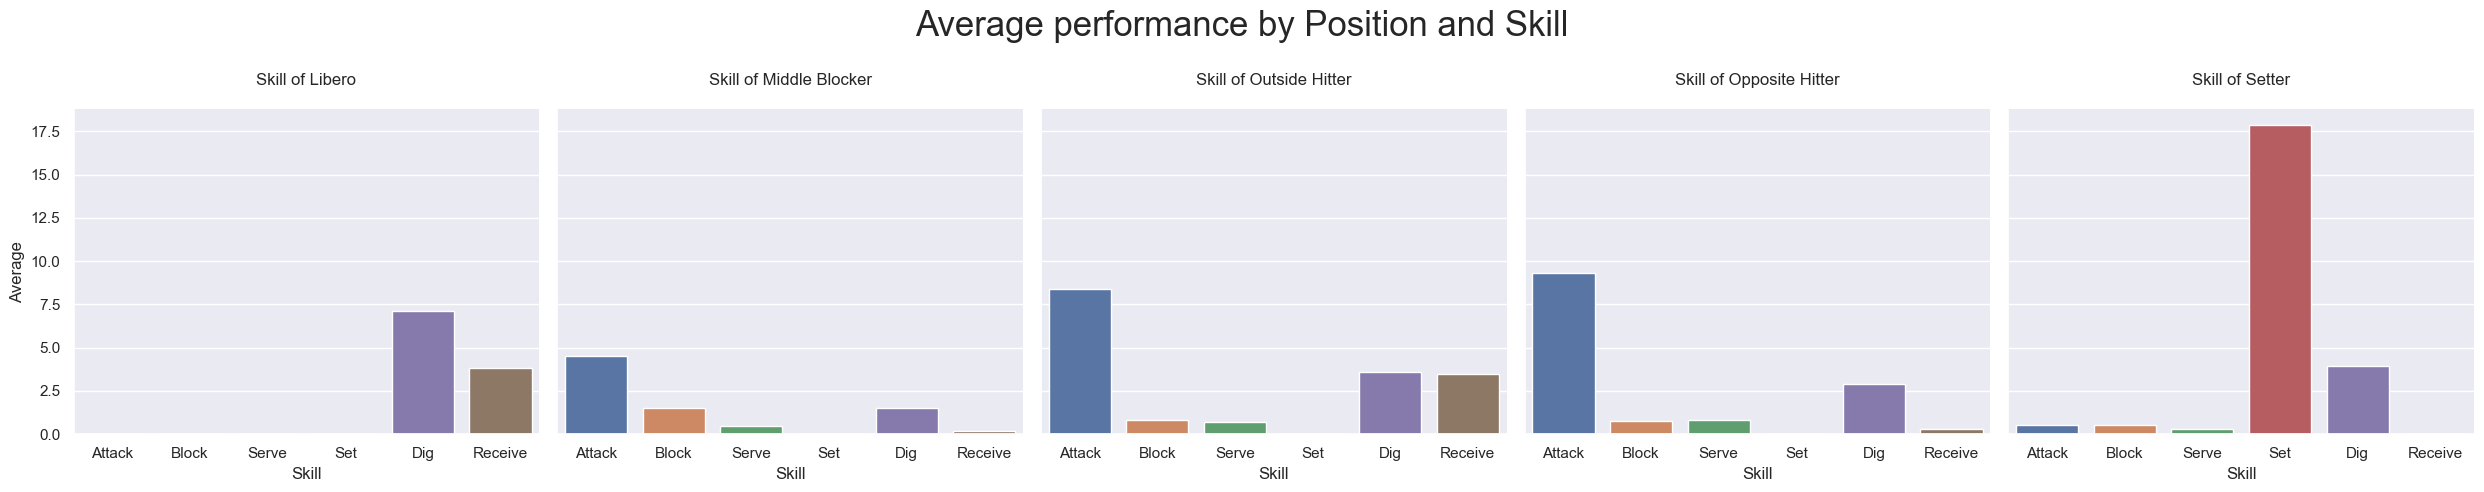

In [20]:
g = sns.catplot(data=pos_long_fmt,
            x="Skill",
            y="Average",
            col="Position",
            hue="Skill",
            kind='bar',
            sharex=False,
            legend=False
            )

g.set_titles("Skill of {col_name}", y=1.05)
g.figure.suptitle("Average performance by Position and Skill", size=25)

g.figure.tight_layout()
plt.show()

We are going to visualize The same data using spider chart

In [21]:
labels = ['Attack', 'Block', 'Serve', 'Set', 'Dig', 'Receive']

# Take the average by position comparing to the max value of each skill in the original data set
values = avg_pos[labels] / vnl23[labels].max(axis=0)
values.index = avg_pos['Position']
values

,Attack,Block,Serve,Set,Dig,Receive
Position,,,,,,
L,0.000000,0.000000,0.000000,0.000000,0.620465,0.573898
MB,0.287638,0.373928,0.228215,0.000093,0.133851,0.026345
OH,0.530485,0.195086,0.341117,0.000823,0.313083,0.521247
OP,0.590253,0.192059,0.385769,0.000223,0.255350,0.041435
S,0.033940,0.136795,0.154447,0.664908,0.344679,0.001588


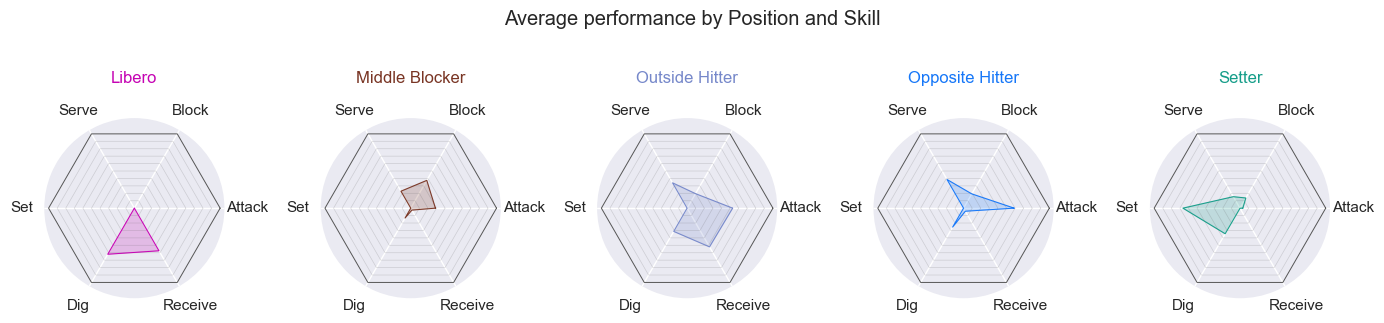

In [22]:
SEED = 0
np.random.seed(SEED)

color_digits = ['0','1','2','3','4','5','6','7','8','9','A','B','C', 'D', 'F']
fig, axes = plt.subplots(ncols=5, figsize=(14, 6), subplot_kw={'polar':True})
for i in range(5):
    color = f"#{''.join(np.random.choice(color_digits, 6, replace=True))}"
    ax = plot_spider(values.iloc[i, :], labels=labels, label=values.index[i], color=color, ax=axes[i])
    ax.set_title(position_name[values.index[i]], y=1.15, color=color)

fig.suptitle("Average performance by Position and Skill", y=0.8)
plt.tight_layout()
plt.show()


Through this plot we can stipulate that:

- The Libero dig and receive
- The Middle blocker attack, alock, and dig
- The Outside Hitter attack, dig, and receive
- The Opposite Hitter attack and dig
- The setter set and dig

To go further in this analysis, we will perform a machine learning task.<br>
The goal is to build a model that accurately predicts a player's position to identify the key features that determine it.<br>
Our goal is to maximize accuracy while keeping the model easily interpretable.

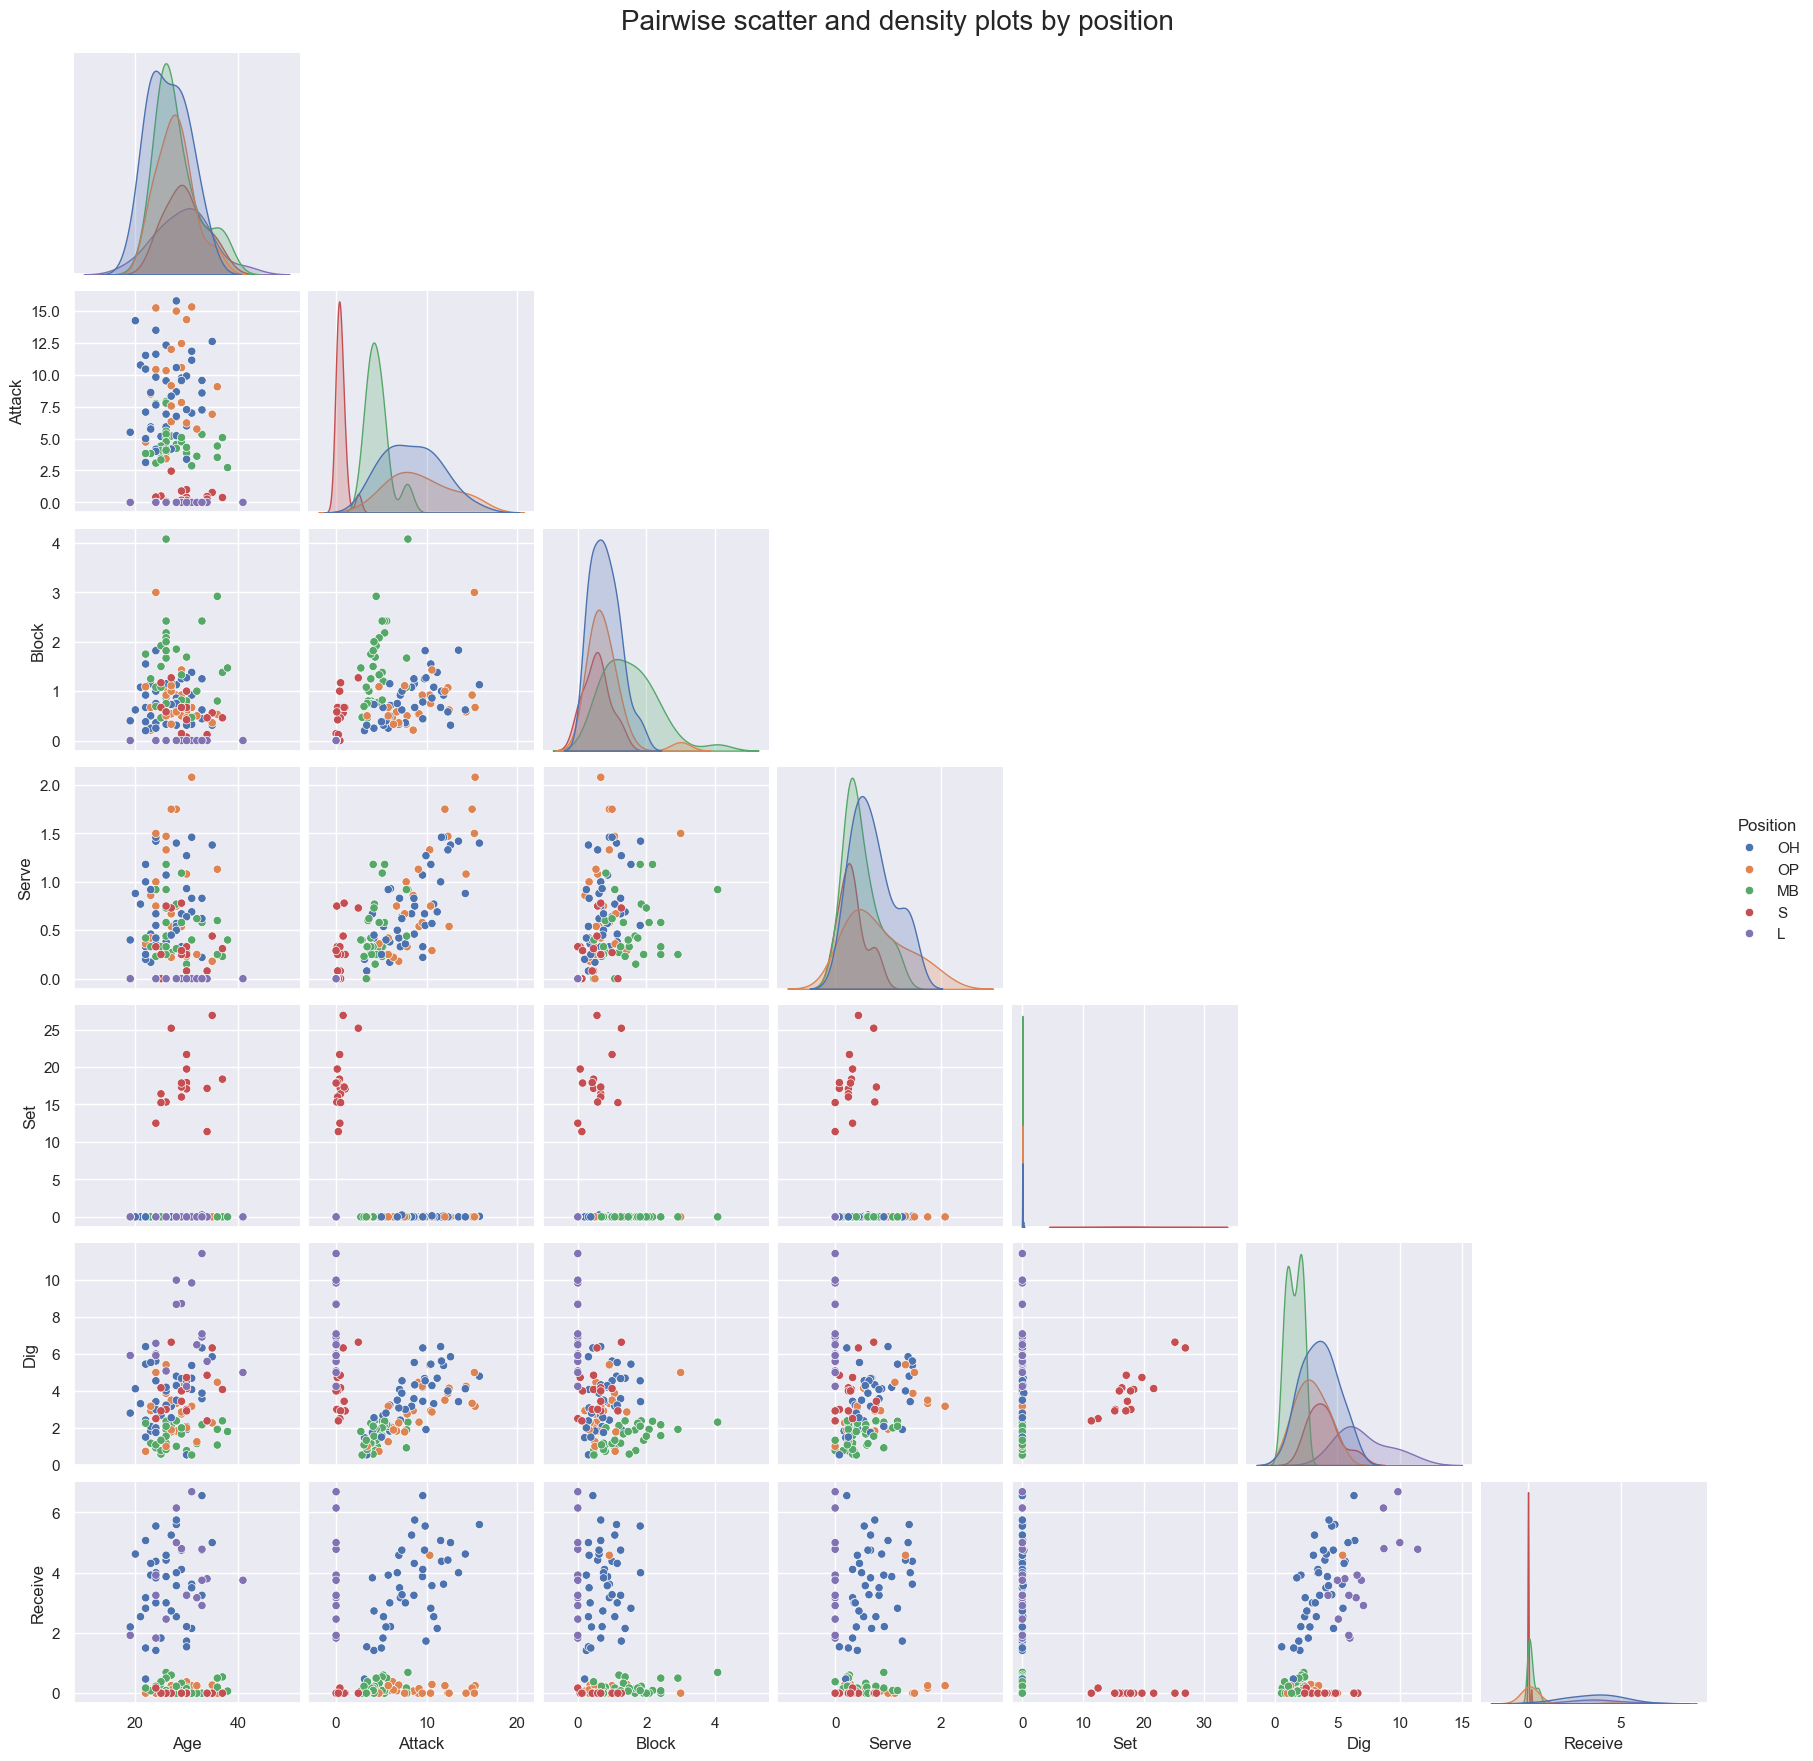

In [23]:
g = sns.pairplot(vnl23, hue='Position', corner=True)
g.figure.suptitle("Pairwise scatter and density plots by position", size=20, y=1.01)

plt.show()

The figure above is a paiwise acatter plot of all numeric features by position. We can see if there is a linear relationship between ours features.<br>
We have also density plot who show us distribution of each feature by position.

In these plots we can notice two which have pretty good linear relationship (Attack vs Serve and Dig vs Receive).<br>
We can see that every plot containing set variable have red dot corresponding to setter away from the other.


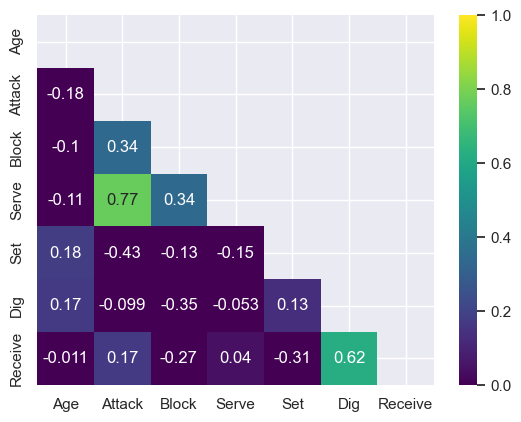

In [24]:
numeric_var = list(vnl23.columns[~(vnl23.dtypes == 'object')])

mask = np.triu(np.ones([len(numeric_var)]*2, dtype=bool))

sns.heatmap(vnl23[numeric_var].corr(), annot=True, mask=mask, vmin=0, vmax=1, cmap='viridis')

plt.show()

The heatmap show us the pretty strong linear relationship than we haved noticed before between (Attack vs Serve and Dig vs Receive)

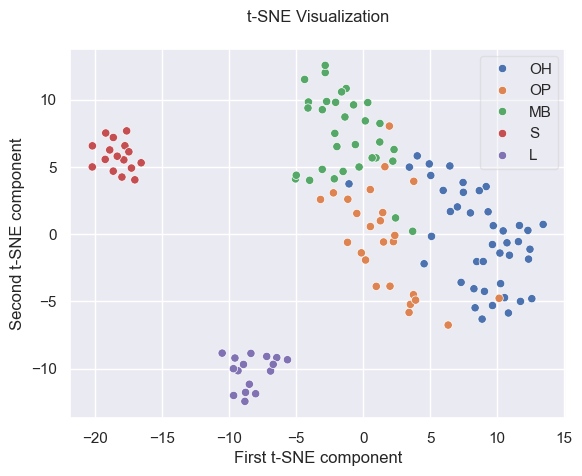

In [25]:
X = vnl23[numeric_var]
scaler = StandardScaler()

X = scaler.fit_transform(X)
tsne = TSNE(learning_rate=100, perplexity=20, random_state=123)
tsne_obs = tsne.fit_transform(X)

obs = pd.DataFrame({
    'x': tsne_obs[:, 0],
    'y': tsne_obs[:, 1],
    'Position': vnl23['Position'].values
})

g = sns.scatterplot(data=obs,
                    x='x',
                    y='y',
                    hue='Position')

g.set_title("t-SNE Visualization", y=1.05)
g.set_xlabel("First t-SNE component")
g.set_ylabel("Second t-SNE component")
plt.legend(framealpha=0.4)

plt.show()

We can see with the t-SNE visualization that observations (players) are pretty well clustered by Position

In [26]:
SEED = 123

X = vnl23[numeric_var]
y = vnl23['Position']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

lr_raw = LogisticRegression(penalty='l1', solver='liblinear')

params ={
    'C' : np.arange(0.1, 1.1, 0.1)
}

lr_grid = GridSearchCV(
    estimator=lr_raw,
    param_grid=params,
    scoring='accuracy',
    cv = 5
)

lr_grid.fit(X_train, y_train)
lr = lr_grid.best_estimator_

print(f"Best gridsearch parameter: {lr_grid.best_params_}")
print(f"Best model score: {lr_grid.best_score_: .2f}")

Best gridsearch parameter: {'C': 0.5}
Best model score:  0.94


In [27]:
print(f"Test score: {lr.score(X_test, y_test)}")

Test score: 1.0


In [28]:
vnl23['Position'].value_counts(normalize=True).apply(lambda x: round(100*x, 2))

Position
OH    32.06
MB    24.43
OP    19.08
S     12.21
L     12.21
Name: proportion, dtype: float64

The model has a training score of 94% and a test score of 100%.<br>
Comparing to a baseline model (The proportion of the dominant class 32%) which classifier <br> all the observations as Outside Hitter(OH)
We can say we have a good model.

In [29]:
coefficients = pd.DataFrame(lr.coef_, index=lr.classes_, columns=numeric_var)
coefficients = coefficients.reset_index(names='Position').melt(id_vars=['Position'], var_name='Feature', value_name="Coef")
coefficients['Coef_sign'] = coefficients['Coef'].apply(lambda x: 'Positive' if x < 0 else 'Negative')
coefficients['Position'] = coefficients['Position'].map(position_name)
coefficients.head()

,Position,Feature,Coef,Coef_sign
0,Libero,Age,0.000000,Negative
1,Middle Blocker,Age,0.173329,Negative
2,Outside Hitter,Age,-0.278339,Positive
3,Opposite Hitter,Age,0.000000,Negative
4,Setter,Age,0.000000,Negative


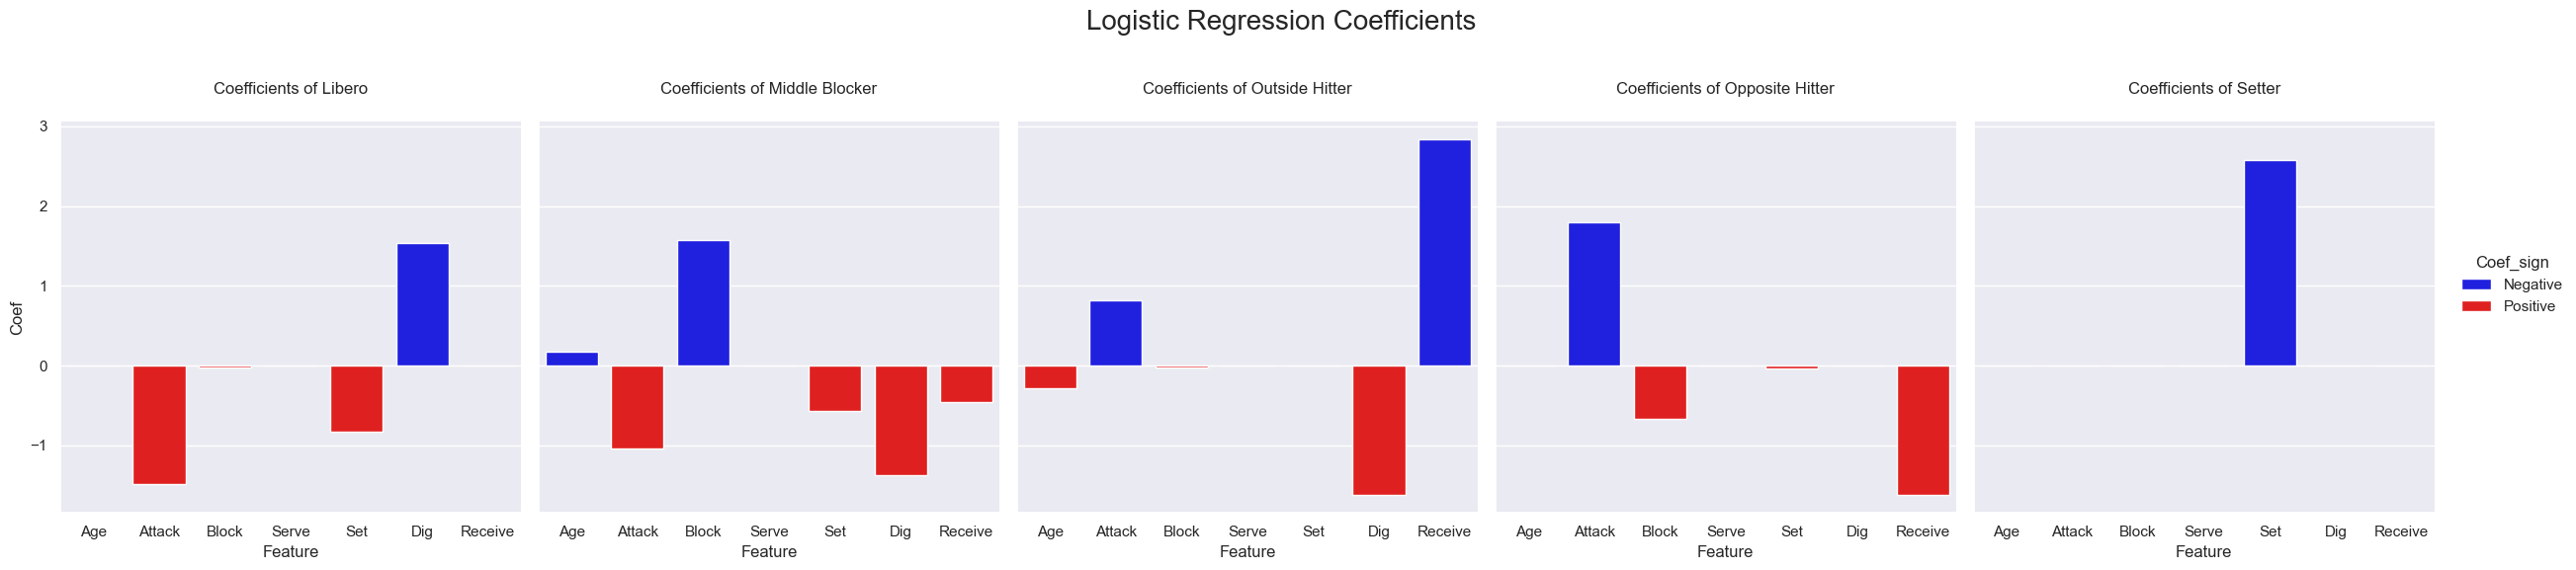

In [30]:
g = sns.catplot(data=coefficients,
                kind='bar',
                x='Feature',
                y='Coef',
                col='Position',
                hue='Coef_sign',
                palette={"Positive": "red", "Negative": "blue"}
                )

g.figure.suptitle('Logistic Regression Coefficients', y=1.15, size=20)
g.set_titles("Coefficients of {col_name}", y=1.05)
plt.show()

A negative coefficient in red indicates that as the feature (skill) value increases, the likelihood of being in that position decreases.<br>
A postive coefficient in blue indicates that as the feature (skill) value increases, the likelihood of being in that position increase.

It's as if the model as extract the core role of each player.
We can conclude that:
- The Libero dig,
- The Middle blocker block,
- The Outside Hitter attack and receive,
- The Opposite Hitter attack,
- The setter set